In [128]:
# imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.metrics import topk_acc, real_acc, AverageMeter
from utils.parsers import get_training_parser
from utils.optimizer import get_optimizer, get_scheduler, OPTIMIZERS_DICT, SCHEDULERS

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt
import argparse
import time


In [3]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
#data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [4]:
# TODO: Do not forget to choose GPU as runtime
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# TODO: Create a folder called 'checkpoints'. It is already included in the .gitignore file
# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)
model

cpu
Weights already downloaded
Load_state output <All keys matched successfully>


BottleneckMLP(
  (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
  (linear_out): Linear(in_features=1024, out_features=10, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x BottleneckBlock(
      (block): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=4096, out_features=1024, bias=True)
      )
    )
  )
  (layernorms): ModuleList(
    (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
)

In [5]:
x = torch.randn(1, 3, 64, 64)
x = x.flatten()
x.shape

torch.Size([12288])

### Import dataset and initialize the DataLoader

In [6]:
transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=1000, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified


### For each class, calculate the mean image

In [89]:
num_class = 10
cmeans = [[] for i in range(num_class)]
r = 0
for x,y in loader:
    r+=1
    for c in range(num_class):
        cmeans[c].append(x[y==c])


In [90]:
clist = [torch.cat(cmeans[i]).mean(dim=0) for i in range(num_class)]

In [ ]:
cclist = [c.unsqueeze(0) for c in clist]
centers = torch.cat(cclist)
centers.shape

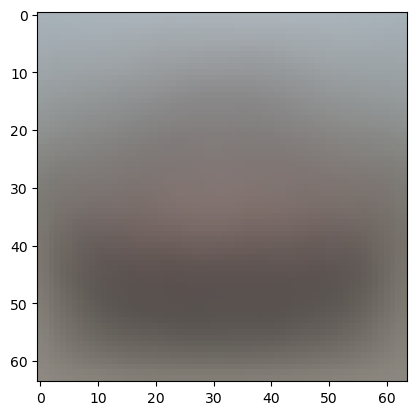

In [91]:
plt.imshow(clist[9].numpy().transpose(1,2,0))

### Define the ClassMaximization class and create an instance of it

In [92]:
x_c = nn.parameter.Parameter(torch.randn(3,64,64))


class ClassMaxim(nn.Module):
    def __init__(self,num_class, centers=None):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(num_class, 3, 64, 64))
        if centers!=None:
            self.x_c = nn.parameter.Parameter(centers.clone())    
        self.clone = self.x_c.clone()

In [94]:
# create the model
clsmax = ClassMaxim(num_class=10, centers=centers)

In [95]:
clsmax.clone==clsmax.x_c

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [100]:
for param in clsmax.parameters():
    print(type(param.data), param.size())

clsmax.x_c[0].shape

<class 'torch.Tensor'> torch.Size([10, 3, 64, 64])


torch.Size([3, 64, 64])

In [110]:
list(clsmax.parameters())

[Parameter containing:
 tensor([[[[0.5686, 0.5681, 0.5661,  ..., 0.5668, 0.5671, 0.5669],
           [0.5690, 0.5684, 0.5664,  ..., 0.5667, 0.5671, 0.5670],
           [0.5688, 0.5682, 0.5661,  ..., 0.5657, 0.5663, 0.5662],
           ...,
           [0.5153, 0.5144, 0.5117,  ..., 0.5086, 0.5098, 0.5100],
           [0.5159, 0.5151, 0.5126,  ..., 0.5089, 0.5097, 0.5098],
           [0.5159, 0.5151, 0.5127,  ..., 0.5086, 0.5093, 0.5092]],
 
          [[0.6323, 0.6318, 0.6297,  ..., 0.6301, 0.6300, 0.6296],
           [0.6327, 0.6321, 0.6301,  ..., 0.6301, 0.6301, 0.6298],
           [0.6327, 0.6320, 0.6297,  ..., 0.6293, 0.6294, 0.6292],
           ...,
           [0.5399, 0.5390, 0.5360,  ..., 0.5337, 0.5348, 0.5349],
           [0.5400, 0.5391, 0.5365,  ..., 0.5333, 0.5341, 0.5341],
           [0.5396, 0.5388, 0.5363,  ..., 0.5326, 0.5333, 0.5333]],
 
          [[0.6989, 0.6984, 0.6963,  ..., 0.6955, 0.6953, 0.6948],
           [0.6992, 0.6986, 0.6965,  ..., 0.6956, 0.6955, 0.6951],
 

In [111]:
parser = get_training_parser()
args = parser.parse_args(args=[])

epoch = 100
num_class=10

loss_fn = CrossEntropyLoss(label_smoothing=args.smooth)
opt = get_optimizer(args.optimizer)(clsmax.parameters(), lr=0.003, weight_decay=args.weight_decay)#args.lr
scheduler = get_scheduler(opt, args.scheduler, **args.__dict__)

In [114]:
start = time.time()
model.eval() # fixed model

# total_acc, total_top5 = AverageMeter(), AverageMeter()
total_loss = AverageMeter()

for step in range(40):
    for c in range(1):
        xx = clsmax.x_c[c].flatten()#.cuda()
        preds = model(xx)
        targs = torch.tensor(c)#.cuda()


        (-preds[c]).backward()
        # loss = loss_fn(preds, targs)
        
        # loss = loss / args.accum_steps
        # loss.backward()

        print(preds[c])
        
        opt.step()
        opt.zero_grad()
    
        #total_loss.update(loss.item() * args.accum_steps, 1)

end = time.time()

scheduler.step()

tensor(1.5574, grad_fn=<SelectBackward0>)
tensor(2.5286, grad_fn=<SelectBackward0>)
tensor(2.7787, grad_fn=<SelectBackward0>)
tensor(3.0540, grad_fn=<SelectBackward0>)
tensor(3.2471, grad_fn=<SelectBackward0>)
tensor(3.3144, grad_fn=<SelectBackward0>)
tensor(3.2991, grad_fn=<SelectBackward0>)
tensor(3.5806, grad_fn=<SelectBackward0>)
tensor(3.7763, grad_fn=<SelectBackward0>)
tensor(3.9521, grad_fn=<SelectBackward0>)
tensor(4.0764, grad_fn=<SelectBackward0>)
tensor(4.1131, grad_fn=<SelectBackward0>)
tensor(4.3527, grad_fn=<SelectBackward0>)
tensor(4.3751, grad_fn=<SelectBackward0>)
tensor(4.6343, grad_fn=<SelectBackward0>)
tensor(4.7068, grad_fn=<SelectBackward0>)
tensor(4.8893, grad_fn=<SelectBackward0>)
tensor(5.0124, grad_fn=<SelectBackward0>)
tensor(5.1493, grad_fn=<SelectBackward0>)
tensor(5.2786, grad_fn=<SelectBackward0>)
tensor(5.3794, grad_fn=<SelectBackward0>)
tensor(5.4742, grad_fn=<SelectBackward0>)
tensor(5.6504, grad_fn=<SelectBackward0>)
tensor(5.6988, grad_fn=<SelectBack

In [116]:
torch.norm(clsmax.x_c[0])

tensor(62.5754, grad_fn=<LinalgVectorNormBackward0>)

In [117]:
torch.norm(centers[0])

tensor(62.3464)

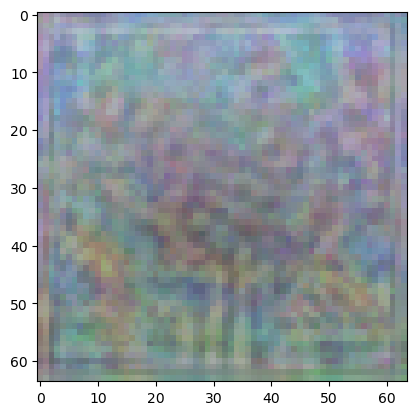

In [118]:
plt.imshow(clsmax.x_c[0].detach().numpy().transpose(1,2,0))

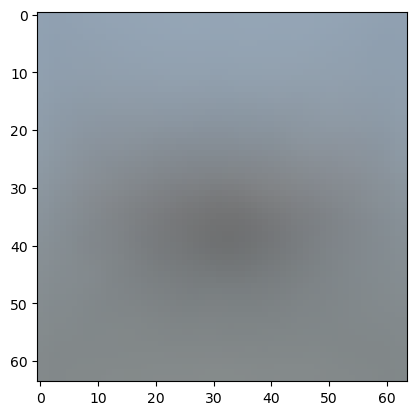

In [119]:
plt.imshow(clsmax.clone[0].detach().numpy().transpose(1,2,0))

In [121]:
clsmax.clone[0]==clsmax.x_c[0]

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False,  True,  True],
         [False, False, False,  ..., False,  True, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [

# Same thing for CNNs

In [141]:
# USE CNN that is pretrained on cifar10

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [122]:
num_class = 10
cmeans = [[] for i in range(num_class)]
r = 0
for x,y in loader:
    r+=1
    for c in range(num_class):
        cmeans[c].append(x[y==c])

In [123]:
clist = [torch.cat(cmeans[i]).mean(dim=0) for i in range(num_class)]

In [124]:
cclist = [c.unsqueeze(0) for c in clist]
centers = torch.cat(cclist)
centers.shape

torch.Size([10, 3, 64, 64])

### Define the ClassMaximization class and create an instance of it

In [ ]:
x_c = nn.parameter.Parameter(torch.randn(3,64,64))

class ClassMaxim(nn.Module):
    def __init__(self,num_class, centers=None):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(num_class, 3, 64, 64))
        if centers!=None:
            self.x_c = nn.parameter.Parameter(centers.clone())    
        self.clone = self.x_c.clone()

In [125]:
# create the model
clsmax = ClassMaxim(num_class=10, centers=centers)

In [126]:
clsmax.clone==clsmax.x_c

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [127]:
parser = get_training_parser()
args = parser.parse_args(args=[])

epoch = 100
num_class=10

loss_fn = CrossEntropyLoss(label_smoothing=args.smooth)
opt = get_optimizer(args.optimizer)(clsmax.parameters(), lr=0.003, weight_decay=args.weight_decay)#args.lr
scheduler = get_scheduler(opt, args.scheduler, **args.__dict__)

In [ ]:
start = time.time()
model.eval() # fixed model

# total_acc, total_top5 = AverageMeter(), AverageMeter()
total_loss = AverageMeter()

for step in range(40):
    for c in range(1):
        xx = clsmax.x_c[c]#.flatten()#.cuda()
        #print(xx.size())
        preds = model(xx)
        print(preds.size())
        targs = torch.tensor(c)#.cuda()


        (-preds[c]).backward()
        # loss = loss_fn(preds, targs)
        
        # loss = loss / args.accum_steps
        # loss.backward()

        print(preds[c])
        
        opt.step()
        opt.zero_grad()
    
        #total_loss.update(loss.item() * args.accum_steps, 1)

end = time.time()

scheduler.step()